# TODO
- <span style="color:red;">split fit and transform in DataFramePreprocessor</span>
- <span style="color:red;">make custom DataFramePreprocesspor run smoothly wih Pipelines</span>

# Preface


In [350]:
# IMPORTS
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score
from scipy.io.arff import loadarff
import arff
from sklearn.grid_search import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import cross_val_score, train_test_split, StratifiedKFold
from collections import Counter
from sklearn.metrics import make_scorer, roc_curve, auc

# DATA IMPORT
dt_golf = pd.read_csv("../data/golf.csv", sep=";")
dt_golf_test = pd.read_csv("../data/golf-testset.csv", sep=";")
dt_iris = pd.read_csv("../data/iris.csv", sep=";", decimal=",", index_col=0)
dt_credit = pd.DataFrame(arff.load(open('../data/credit-g.arff', 'r'))["data"], 
                         columns = pd.DataFrame(loadarff("../data/credit-g.arff")[0]).columns)

In [542]:
# CUSTOM MODULES
#%load "../models/DataFramePreprocessor.py"
#%load "../models/Utilities.py"

---
# Task 3.1: Golf Dataset – Decision Tree
Learn a decision tree from the Golf dataset (Operator: Decision Tree). Use this tree to classify the examples in the Golf-Testset, which is also delivered together with RapidMiner (Operator: Apply Model). For how many objects does the trained tree predict the correct value?

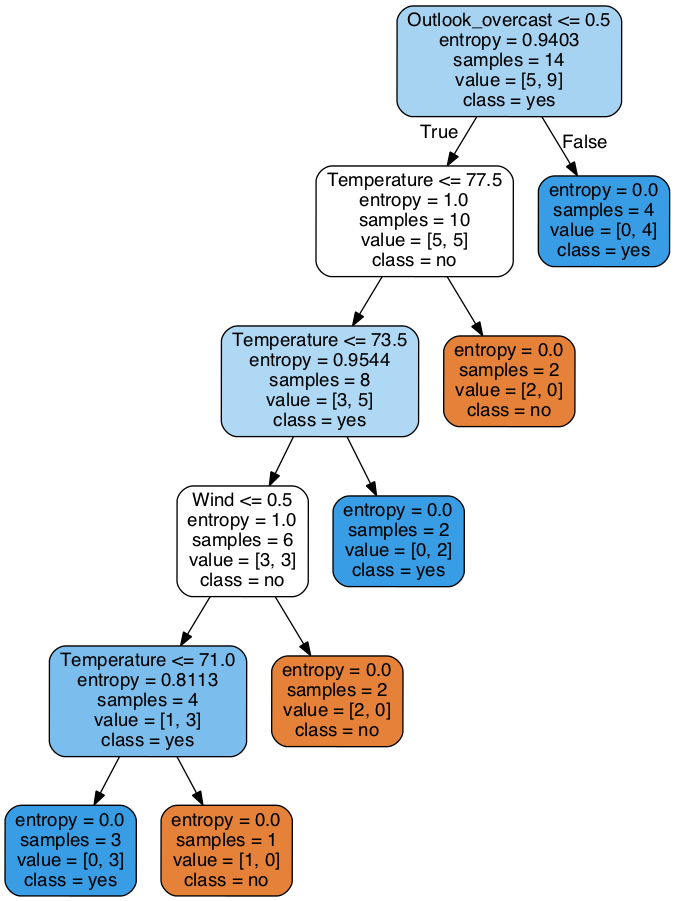

In [379]:
# Initiate preprocessor and transform data
dfp = DataFramePreprocessor()
X, y = dfp.fit_transform(dt_golf, "Play")

# Initiate and learn DecisionTreeClassifier
dtree = DecisionTreeClassifier(criterion='entropy')
dtree.fit(X,y)

# Plot the decision tree
plot_decision_tree(X.columns, dfp.label_encoder.classes_, dtree, path="../figures/classification/tree-golf.dot")

In [380]:
# Test the decision tree on the unseen data
X_test, y_test = dfp.fit_transform(dt_golf_test, "Play")
y_pred = pd.DataFrame(dtree.predict(X_test),
                      index = y_test.index,
                      columns = ["{}_pred".format(y_test.columns[0])]
                     )

# Evaluate the decision tree
np.sum(y_test.values == y_pred.values)

7

The Decision Tree predictes correctly in 7 cases.

---
# Task 3.2: Golf Dataset – Evaluation
Evaluate the performance of your model by adding a Performance (Classification) operator to your process. Examine the confusion matrix. What is the accuracy of your classifier?

<module 'matplotlib.pyplot' from '/Users/joshuagorner/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py'>

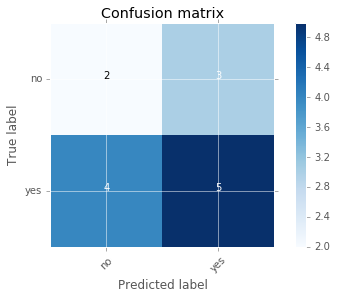

In [381]:
# Create and visualize the confusion matrix 
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, dfp.label_encoder.classes_)

In [382]:
# Evaluate the accuracy score
accuracy_score(y_test, y_pred)

0.5

The accuracy score is 50% (7 out of 14), hence the Decision Tree is not better than random guessing.

---
# Task 3.3: Golf Dataset – k-NN
Does a k-Nearest-Neighbor (k-NN) classifier work better for this task? To find out, replace the Decision Tree operator with a k-NN operator and evaluate the trained model using different values for k. What is the best accuracy you can reach?

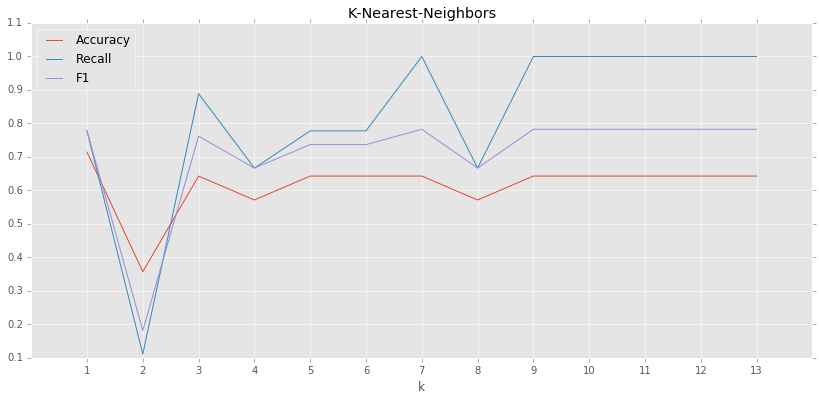

In [383]:
# Settings for parameter tuning
k_limits = [1, 14]
k_results_acc = np.zeros(k_limits[1]-k_limits[0])
k_results_rec = np.zeros(k_limits[1]-k_limits[0])
k_results_f1 = np.zeros(k_limits[1]-k_limits[0])

# Parameter evaluation based on accuracy, recall and F1
for idx, k in enumerate(np.arange(k_limits[0], k_limits[1])):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X,y.values.ravel())
    y_pred = knn.predict(X_test)
    k_results_acc[idx] = accuracy_score(y_test, y_pred)
    k_results_rec[idx] = recall_score(y_test, y_pred)
    k_results_f1[idx] = f1_score(y_test, y_pred)

# Plot parameter evaluation
plt.rcParams["figure.figsize"] = [14, 6]
plt.plot(np.arange(k_limits[0], k_limits[1]), k_results_acc, label="Accuracy")
plt.plot(np.arange(k_limits[0], k_limits[1]), k_results_rec, label="Recall")
plt.plot(np.arange(k_limits[0], k_limits[1]), k_results_f1, label="F1")
plt.title("K-Nearest-Neighbors")
plt.xlabel("k")
plt.xticks(np.arange(1,14))
plt.yticks(np.arange(0.1,1.2, 0.1))
plt.legend(loc="best")
plt.savefig("../figures/classification/golf-knn-parameter-tuning.png")
plt.show()

The highest achievable accuracy result is ~71.43% for `k=1` neighbors.

---
# Task 3.4 Iris Flowers – ID3
Set up the process as described above. What accuracy can you reach using the ID3 decision tree?
<span style="color:red;">ID3 =? usage of Entropy</span>

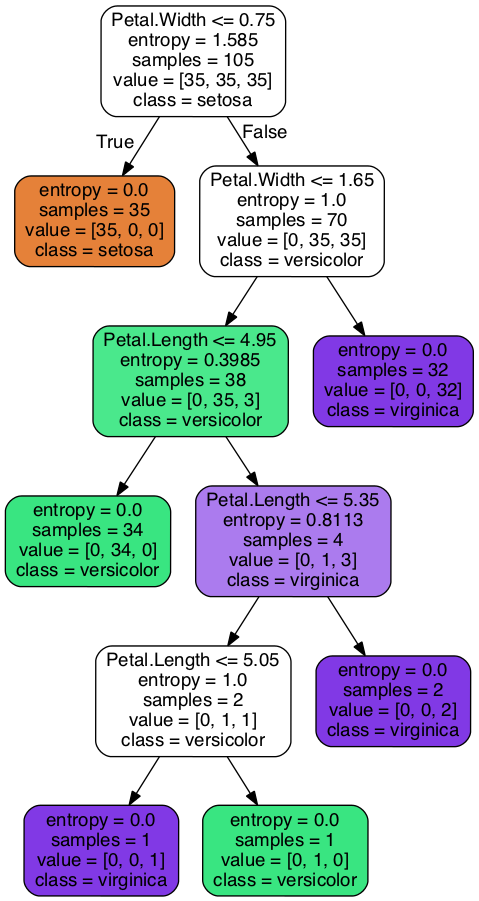

In [395]:
# Initiate preprocessor and transform data
dfp_iris = DataFramePreprocessor(encode=False)
X, y = dfp_iris.fit_transform(dt_iris, "Species")

# Train test split the dataset
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, stratify=y)

# Initiate and train the DecisionTreeLearner
dtree_iris = DecisionTreeClassifier(criterion='entropy')
dtree_iris.fit(X_train, y_train)

# Plot the decision tree
plot_decision_tree(X_train.columns,
                   np.unique(dfp_iris.inverse_transform_label(y_train)),
                   dtree_iris,
                   path="../figures/classification/tree-iris.dot")

In [396]:
# Evaluate the accuracy of the Decision Tree
dtree_iris.score(X_test, y_test)

0.93333333333333335

The achieved accuracy is 93%.

---
# Task 3.5: Iris Flowers – Decision Tree
What accuracy can be reached using this kind of decision tree algorithm?
Compare the different trained models (trees). In case you would need to
interpret the model as human, which model would you use and why? (Hint:
Keep in mind Occam’s Razor.)

<span style="color:red;">What are the "different" models?"</span>

---
# Task 3.6: Credit Dataset – ROC
Apply the Compare ROCs operator to the dataset and include k-NN (with different values for k), Decision Tree, Naive Bayes and Rule Induction. Which classification approach looks most promising to you?<br><br>
**Sidenote: Unfortunately rule-based-learning is not supported by sklearn**

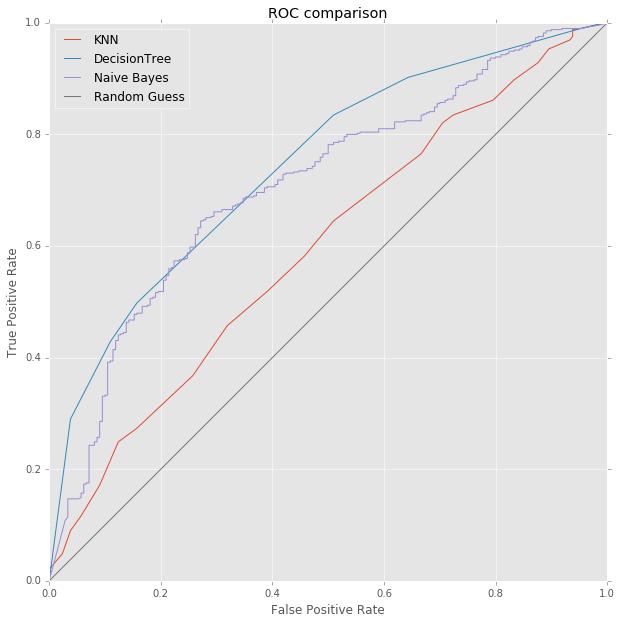

In [397]:
# Preprocess data
dfp_credit = DataFramePreprocessor()
X, y = dfp_credit.fit_transform(dt_credit, "class")

# Train test plit data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.3, stratify=y, random_state=42)

# KNN - tuning of hyperparameter
# Search optimal k in [1, 100]
pg_knn =[{"n_neighbors" : np.arange(1,101)}] 
gs = GridSearchCV(estimator=KNeighborsClassifier(),
                  param_grid=pg_knn,
                  cv=10)
knn_best = gs.fit(X.values, y.values.ravel()).best_estimator_

# Decision Trees - tuning of hyperparameter
# Search for optimal max_depth and criterion
pg_dtree =[{"max_depth" : [2, 3, 5, 10],
            "criterion" : ["gini", "entropy"]}] 
gs = GridSearchCV(estimator=DecisionTreeClassifier(),
                  param_grid=pg_dtree,
                  cv=10)
dtree_best = gs.fit(X.values, y.values.ravel()).best_estimator_

# Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train.values.ravel())

# Prepare ROC data
fpr_knn, tpr_knn, _ = roc_curve(y_test, knn_best.predict_proba(X_test).T[1])
fpr_dtree, tpr_dtree, _ = roc_curve(y_test, dtree_best.predict_proba(X_test).T[1])
fpr_nb, tpr_nb, _ = roc_curve(y_test, nb.predict_proba(X_test).T[1])

# Plot ROC curves
plt.rcParams["figure.figsize"] = [10, 10]
plt.plot(fpr_knn, tpr_knn, label="KNN")
plt.plot(fpr_dtree, tpr_dtree, label="DecisionTree")
plt.plot(fpr_nb, tpr_nb, label="Naive Bayes")
plt.plot([0,1], [0,1], label="Random Guess")
plt.title("ROC comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="best")
plt.savefig("../figures/classification/roc-comparison.png")
plt.show()

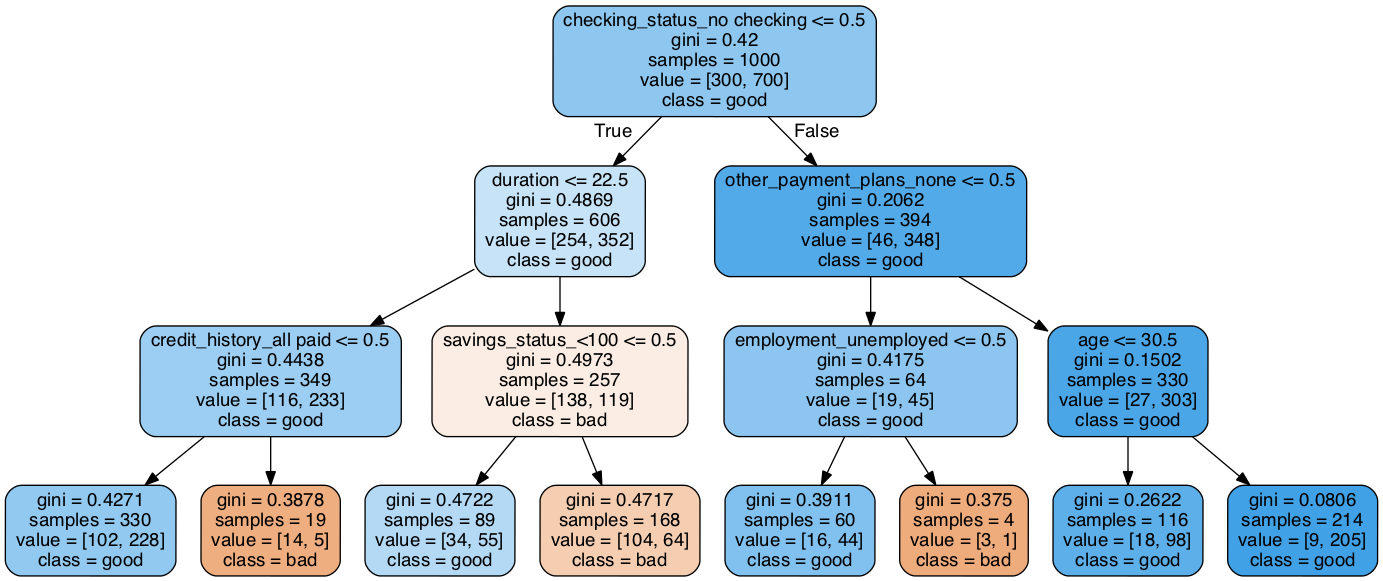

In [12]:
# Show best classifier
plot_decision_tree(X_train.columns, 
                   np.unique(dfp_credit.inverse_transform_label(y_train)), 
                   dtree_best, 
                   path="../figures/classification/tree-credit.dot")

---
# Task 3.7: Credit Dataset – X-Validation
What accuracy levels can you reach by using a 10-fold x-validation?

In [13]:
# KNN 10-fold cross validation scores
scores_knn = cross_val_score(estimator = knn_best,
                             X = X,
                             y = y.values.ravel(),
                             cv = 10)

# Decision Tree 10-fold cross validation scores
scores_dtree = cross_val_score(estimator = dtree_best,
                               X = X,
                               y = y.values.ravel(),
                               cv = 10)

# Naive Bayes 10-fold cross validation scores
scores_nb = cross_val_score(estimator = nb,
                            X = X,
                            y = y.values.ravel(),
                            cv = 10)

# Results
print("BEST SCORES\nKNN:\t{}\nDTree:\t{}\nNB:\t{}".format(np.mean(scores_knn),
                                                          np.mean(scores_dtree),
                                                          np.mean(scores_nb)))

BEST SCORES
KNN:	0.709
DTree:	0.72
NB:	0.714


---
# Task 3.8: Credit Dataset – Balancing
Filter the examples of the bad customers within the training part of the x-validation and append them multiple times to the dataset used for training. How does the change influence the accuracy and the number of falsely classified bad customers?

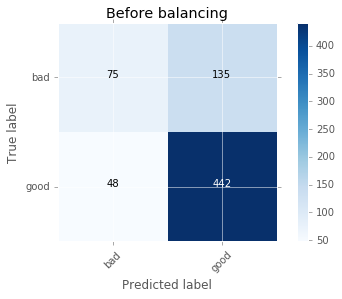

In [663]:
# Before balancing the classes
cm_before = confusion_matrix(y_test.values.ravel(), dtree_best.predict(X_test))
plot_confusion_matrix(cm_before, dfp_credit.label_encoder.classes_, title="Before balancing")
plt.show()

In [574]:
np.bincount(y_train.values.ravel())

array([ 90, 210])

The exact inbalance in the current train set is 90("bad") to 210("good"). To get a rough balance between the classes, the set of bad customers is therefore doubled resulting in a ratio of 180/210 ~ 1.

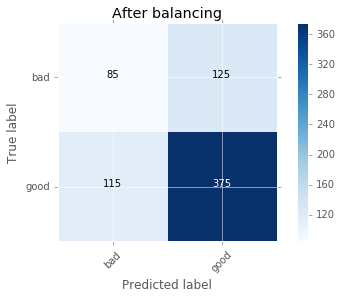

In [684]:
# Create mock bad customers attributes and labels
X_train_bad_mock = X_train.ix[y_train["class"] == 0,:]
X_train_bad_mock.index = np.arange(X_train_bad_mock.shape[0])-X_train_bad_mock.shape[0]
y_train_bad_mock = pd.DataFrame(np.repeat(0, X_train_bad_mock.shape[0]),
                                index = X_train_bad_mock.index,
                                columns = y_train.columns
                               )

# Append mock bad customers to train data
X_train_mock = pd.concat([X_train, X_train_bad_mock])
y_train_mock = pd.concat([y_train, y_train_bad_mock])

# Initiate DecisionTreeLearner and learn on mock train data
dtree_mock = DecisionTreeClassifier(max_depth=3)
dtree_mock.fit(X_train_mock, y_train_mock)

# Confusion Matric after balancing the classes
cm_after = confusion_matrix(y_test.values.ravel(), dtree_mock.predict(X_test))
plot_confusion_matrix(cm_after, dfp_credit.label_encoder.classes_, title="After balancing")
plt.show()

In [667]:
cm_after-cm_before

array([[ 10, -10],
       [ 67, -67]])

After doubling the number of bad customers the decision tree became more "suspicious" meaning that it is less willing to classify a customer as a good customer. Compared to the scenario before doubling the bad customers, the new algorithm "missed" 67 potential customers but therefore rejected 10 additional bad customers.

---
# Task 3.9: Credit Dataset – Cost-specific Performance
Set up the cost matrix of the Performance (Cost) operator by assuming that you will lose 1 unit if you refuse a credit to a good customer, but that you lose 100 units if you give a bad customer a credit. Rerun the setup with the different classification algorithms and x-validation. Find the best setup for this cost assumption. (Hint: The best results will have the lowest misclassification costs.)

In [681]:
# Apply cost model to task 3.8
cost = [[0, -100],
       [-1, 0]]

# Cost before doubling bad customers in train dataset
print("Before: {}".format(np.sum(cost*cm_before)))

# Cost after doubling bad customers in train dataset
print("After: {}".format(np.sum(cost*cm_after)))
print("Saved: {}".format(np.sum(cost*cm_after) - np.sum(cost*cm_before)))

Before: -13548
After: -12615
Saved: 933


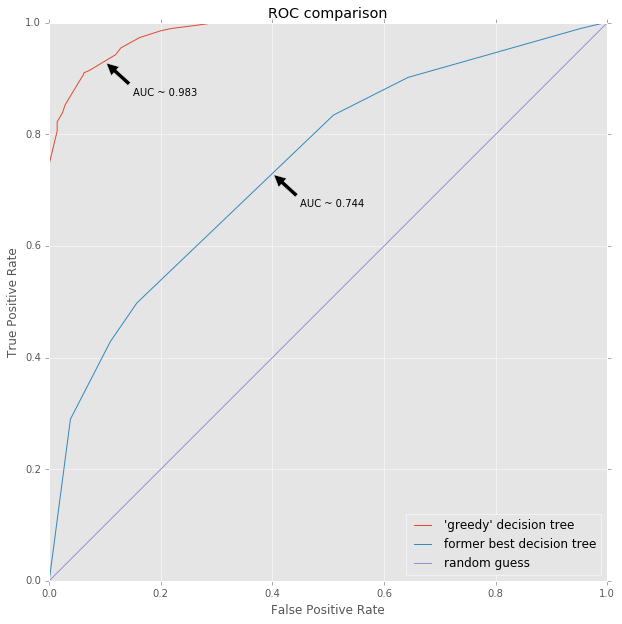

In [345]:
# Custom cost function
def credit_cost_function(y, y_pred):
    cost = 0
    deviation = Counter(y-y_pred)
    if 1 in deviation.keys():
        cost += deviation.get(1)*-1 
    if -1 in deviation.keys():
        cost +=deviation.get(-1)*-100
    return cost

# Custom scorer to be used in gridsearch
cost_scorer = make_scorer(credit_cost_function)

# Grid search for optimal parameter
pg_dtree =[{"max_depth" : [2, 3, 5, 10],
            "criterion" : ["gini", "entropy"]}] 
gs = GridSearchCV(estimator = DecisionTreeClassifier(),
                  param_grid = pg_dtree,
                  cv = 10,
                  scoring = cost_scorer
                 )
gs_result = gs.fit(X.values, y.values.ravel())
dtree_greedy = gs_result.best_estimator_

# Compute and plot ROC curve
fpr_greedy, tpr_greedy, _ = roc_curve(y_test, dtree_greedy.predict_proba(X_test).T[1])
fpr_dtree, tpr_dtree, _ = roc_curve(y_test, dtree_best.predict_proba(X_test).T[1])
plt.plot(fpr_greedy, tpr_greedy, label="'greedy' decision tree")
plt.plot(fpr_dtree, tpr_dtree, label="former best decision tree" )
plt.annotate('AUC ~ %.3f' % round(auc(fpr_greedy, tpr_greedy), 4), 
             xy=(0.1, 0.93), 
             xytext=(0.15, 0.87),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('AUC ~ %.3f' % round(auc(fpr_dtree, tpr_dtree), 4),
             xy=(0.4, 0.73),
             xytext=(0.45, 0.67),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.plot([0, 1], [0, 1], label="random guess")
plt.title("ROC comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="best")
#plt.savefig("../figures/classification/roc-comparison-decision-trees.png")
plt.show()

An increasing number of the parameter "max_depth" (max depth of decision tree) tends to lead to lower cost. The following plot shall indicate the relationship between max_depth vs. cost

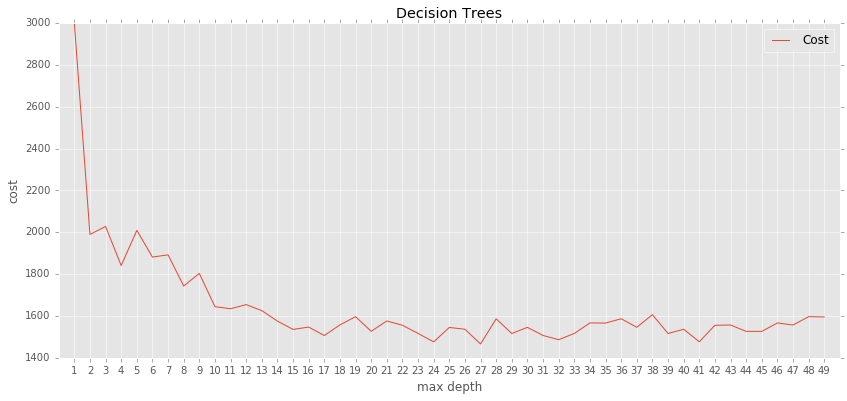

In [89]:
# Settings for parameter tuning
depth_limits = [1, 50]
depth_results_cost = np.zeros(depth_limits[1]-depth_limits[0])

# Parameter evaluation based on cost scoring via 10-fold CV
for idx, d in enumerate(np.arange(depth_limits[0], depth_limits[1])):
    dtree = DecisionTreeClassifier(max_depth = d)
    depth_results_cost[idx] = -np.mean(cross_val_score(estimator = dtree,
                                                      X = X,
                                                      y = y.values.ravel(),
                                                      cv = 10,
                                                      scoring = cost_scorer))
                               
# Plot parameter evaluation
plt.rcParams["figure.figsize"] = [14, 6]
plt.plot(np.arange(depth_limits[0], depth_limits[1]), depth_results_cost, label="Cost")
plt.title("Decision Trees")
plt.xlabel("max depth")
plt.ylabel("cost")
plt.xticks(np.arange(1,depth_limits[1]))
plt.legend(loc="best")
plt.savefig("../figures/classification/max-depth-vs-cost.png")
plt.show()

---
# Task 3.10: Credit Dataset – Noise
We have learned that in most cases labels are created by manual annotators. Humans tend to be fallible and we can assume that some of our training data might include noise. We can simulate this behaviour using the Add Noise operator (Rapidminer only) and change the parameter label noise from 0 % to 5 % to 10 % to 20 %. You can get a fast impression of the performance by using ROC (as in the  rst task).Is your preferred classification approach still feasible for this situation? How does the performance of the other classifiers evolve?

## Description of the `Add Noise` operator
Taken from: [Rapidminer Documentation - Add Noise](http://docs.rapidminer.com/studio/operators/utility/data_generation/add_noise.html)<br>
*The Add Noise operator provides a number of parameters for selecting the attributes for adding noise in them. This operator can add noise to the label attribute or to the regular attributes separately. [...] **For nominal labels the label noise parameter defines the probability to randomly change the nominal label value**.* <br><br>




## Python implementation for `add noise`
The following implementation is restricted to nominal, binary attributes/labels only. To get the positions of the idices randomly, an unordered sampling without replacement is used via **`numpy.random.choice`** [Official Documentation](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.choice.html#numpy.random.choice)

In [348]:
# Add noise to labels
y_noise_05 = add_noise(y, 0.05)
y_noise_10 = add_noise(y, 0.1)
y_noise_20 = add_noise(y, 0.2)

# Calculate based achievable costs for noisy data
print("Noise 00%: {}\nNoise 05%: {}\nNoise 10%: {}\nNoise 20%: {}"
      .format(np.mean(cross_val_score(dtree_greedy, X, y.values.ravel(), cv=10, scoring=cost_scorer)),
              np.mean(cross_val_score(dtree_greedy, X, y_noise_05.values.ravel(), cv=10, scoring=cost_scorer)),
              np.mean(cross_val_score(dtree_greedy, X, y_noise_05.values.ravel(), cv=10, scoring=cost_scorer)),
              np.mean(cross_val_score(dtree_greedy, X, y_noise_05.values.ravel(), cv=10, scoring=cost_scorer))))

Noise 00%: -1664.1
Noise 05%: -1796.9
Noise 10%: -1786.9
Noise 20%: -1816.3


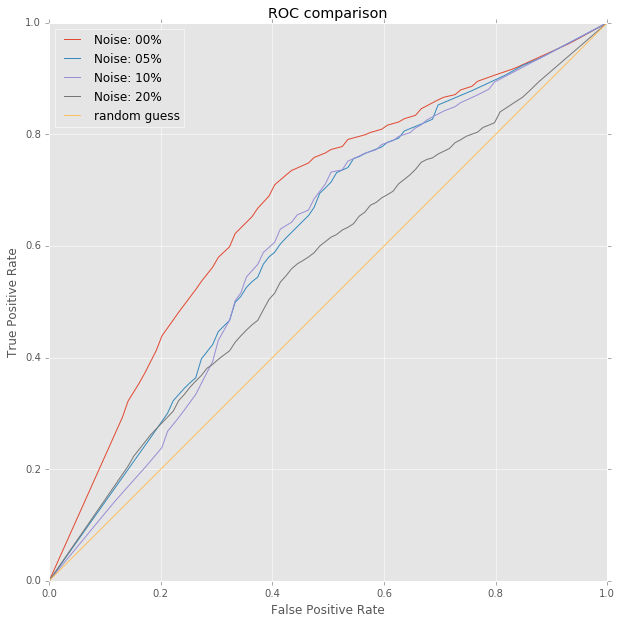

In [349]:
# Calculate the mean ROC values for noisy data
cv_fpr_noise_00, cv_tpr_noise_00 = roc_mean_from_cv(dtree_greedy, X, y)
cv_fpr_noise_05, cv_tpr_noise_05 = roc_mean_from_cv(dtree_greedy, X, y_noise_05)
cv_fpr_noise_10, cv_tpr_noise_10 = roc_mean_from_cv(dtree_greedy, X, y_noise_10)
cv_fpr_noise_20, cv_tpr_noise_20 = roc_mean_from_cv(dtree_greedy, X, y_noise_20)


# Plot and compare the ROC curves
plt.plot(cv_fpr_noise_00, cv_tpr_noise_00, label="Noise: 00%")
plt.plot(cv_fpr_noise_05, cv_tpr_noise_05, label="Noise: 05%")
plt.plot(cv_fpr_noise_10, cv_tpr_noise_10, label="Noise: 10%")
plt.plot(cv_fpr_noise_20, cv_tpr_noise_20, label="Noise: 20%")

plt.plot([0, 1], [0, 1], label="random guess")
plt.title("ROC comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="best")
plt.savefig("../figures/classification/roc-comparison-noise.png")
plt.show()

As one can see, the more noise the worse the predicion quality of the decision tree classifier. Other classification models shall be inspected for a more robust estimation of noisy data.